<a href="https://colab.research.google.com/github/Sonica-B/Computer-Vision-CS-549/blob/HW0/HW0/ssboyane_hw0/HW0Phase1AndPhase2Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s):
Prof. Nitin J. Sanket (nsanket@wpi.edu), Lening Li (lli4@wpi.edu), Gejji, Vaishnavi Vivek (vgejji@wpi.edu)

Robotics Engineering Department,

Worcester Polytechnic Institute

Code adapted from CMSC733 at the University of Maryland, College Park.


## Phase 1




### Get the BSDS500 dataset

In [25]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!mv BSDS500/ /content/data/

--2025-01-11 02:17:52--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812060 (793K) [application/octet-stream]
Saving to: ‘BSDS500.tar.xz.2’

BSDS500.tar.xz.2    100%[===================>] 793.03K  --.-KB/s    in 0.03s   

2025-01-11 02:17:52 (25.4 MB/s) - ‘BSDS500.tar.xz.2’ saved [812060/812060]

BSDS500/
BSDS500/CannyBaseline/
BSDS500/CannyBaseline/1.png
BSDS500/CannyBaseline/10.png
BSDS500/CannyBaseline/2.png
BSDS500/CannyBaseline/3.png
BSDS500/CannyBaseline/4.png
BSDS500/CannyBaseline/5.png
BSDS500/CannyBaseline/6.png
BSDS500/CannyBaseline/7.png
BSDS500/CannyBaseline/8.png
BSDS500/CannyBaseline/9.png
BSDS500/GroundTruth/
BSDS500/GroundTruth/1.png
BSDS500/GroundTruth/10.png
BSDS

In [26]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!mv TxtFiles/ /content/data/

--2025-01-11 02:17:55--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55376 (54K) [application/octet-stream]
Saving to: ‘TxtFiles.tar.xz.2’

TxtFiles.tar.xz.2   100%[===================>]  54.08K  --.-KB/s    in 0.009s  

2025-01-11 02:17:56 (5.70 MB/s) - ‘TxtFiles.tar.xz.2’ saved [55376/55376]

TxtFiles/
TxtFiles/DirNamesTest.txt
TxtFiles/DirNamesTrain.txt
TxtFiles/LabelsTest.txt
TxtFiles/LabelsTrain.txt
mv: cannot move 'TxtFiles/' to '/content/data/TxtFiles': Directory not empty


In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

1. Generate Difference of Gaussian Filter Bank: (DoG)
2. Display all the filters in this filter bank and save image as DoG.png,
3. use command "cv2.imwrite(...)"

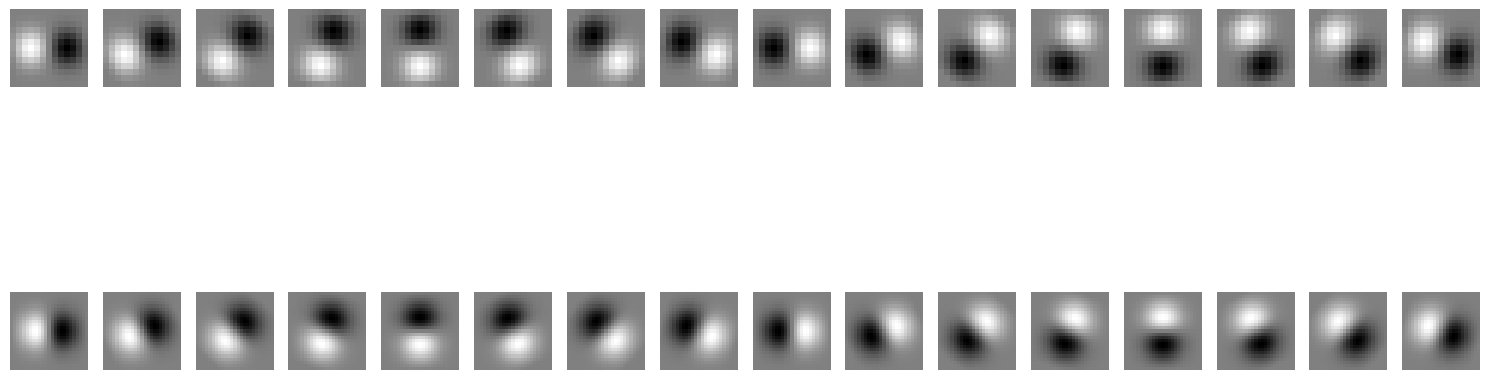

DoG filter bank saved as 'DoG.png'


In [28]:
####  TEST1

# Function to create Gaussian kernel
def gaussian_kernel(size, sigma_x,sigma_y=None):
    # ax = np.linspace(-(size // 2), size // 2, size)
    # x, y = np.meshgrid(ax, ax)
    # kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    # return kernel / kernel.sum()
    if sigma_y is None:
      sigma_y = sigma_x

    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)

    # Calculate 2D Gaussian with possibly different x and y spreads
    gaussian = np.exp(-(x**2 / (2*sigma_x**2) + y**2 / (2*sigma_y**2)))

    return gaussian / gaussian.sum()

# Function to create Sobel operators
def sobel_filters():
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])
    return sobel_x, sobel_y

# Function to rotate a filter by a given angle
def rotate_filter(filter, angle):
    size = filter.shape[0]
    center = size // 2
    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)
    rotated_filter = cv2.warpAffine(filter, rotation_matrix, (size, size))
    return rotated_filter

# Function to generate the DoG filter bank
def generate_dog_filter_bank(scales, orientations):
    filters = []
    sobel_x, sobel_y = sobel_filters()

    for scale in scales:
        # Generate Gaussian kernel
        size = int(scale * 6)  # Kernel size proportional to scale
        if size % 2 == 0:  # Ensure odd size
            size += 1
        gaussian = gaussian_kernel(size, scale)

        # Compute Derivatives of Gaussian (DoG)
        dog_x = np.convolve(gaussian.flatten(), sobel_x.flatten(), mode='same').reshape(size, size)
        dog_y = np.convolve(gaussian.flatten(), sobel_y.flatten(), mode='same').reshape(size, size)

        # Rotate DoG filters to generate orientations
        for orientation in range(orientations):
            angle = (360 / orientations) * orientation
            rotated_x = rotate_filter(dog_x, angle)
            rotated_y = rotate_filter(dog_y, angle)
            filters.append(rotated_x + rotated_y)  # Combine x and y derivatives

    return filters

# Parameters
scales = [2, 4]  # Two scales
orientations = 16  # 16 orientations

# Generate filter bank
dog_filter_bank = generate_dog_filter_bank(scales, orientations)

# Display the filter bank
rows = len(scales)
cols = orientations
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(dog_filter_bank[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Save the filter bank as an image
dog_image = np.zeros((rows * 31, cols * 31))  # Assuming filter size is 31x31
for i in range(rows):
    for j in range(cols):
        filter_resized = cv2.resize(dog_filter_bank[i * cols + j], (31, 31))
        dog_image[i * 31:(i + 1) * 31, j * 31:(j + 1) * 31] = filter_resized

cv2.imwrite("DoG.png", (dog_image * 255).astype(np.uint8))
print("DoG filter bank saved as 'DoG.png'")



1. Generate Leung-Malik Filter Bank: (LM)
2. Display all the filters in this filter bank and save image as LM.png,
3. use command "cv2.imwrite(...)"


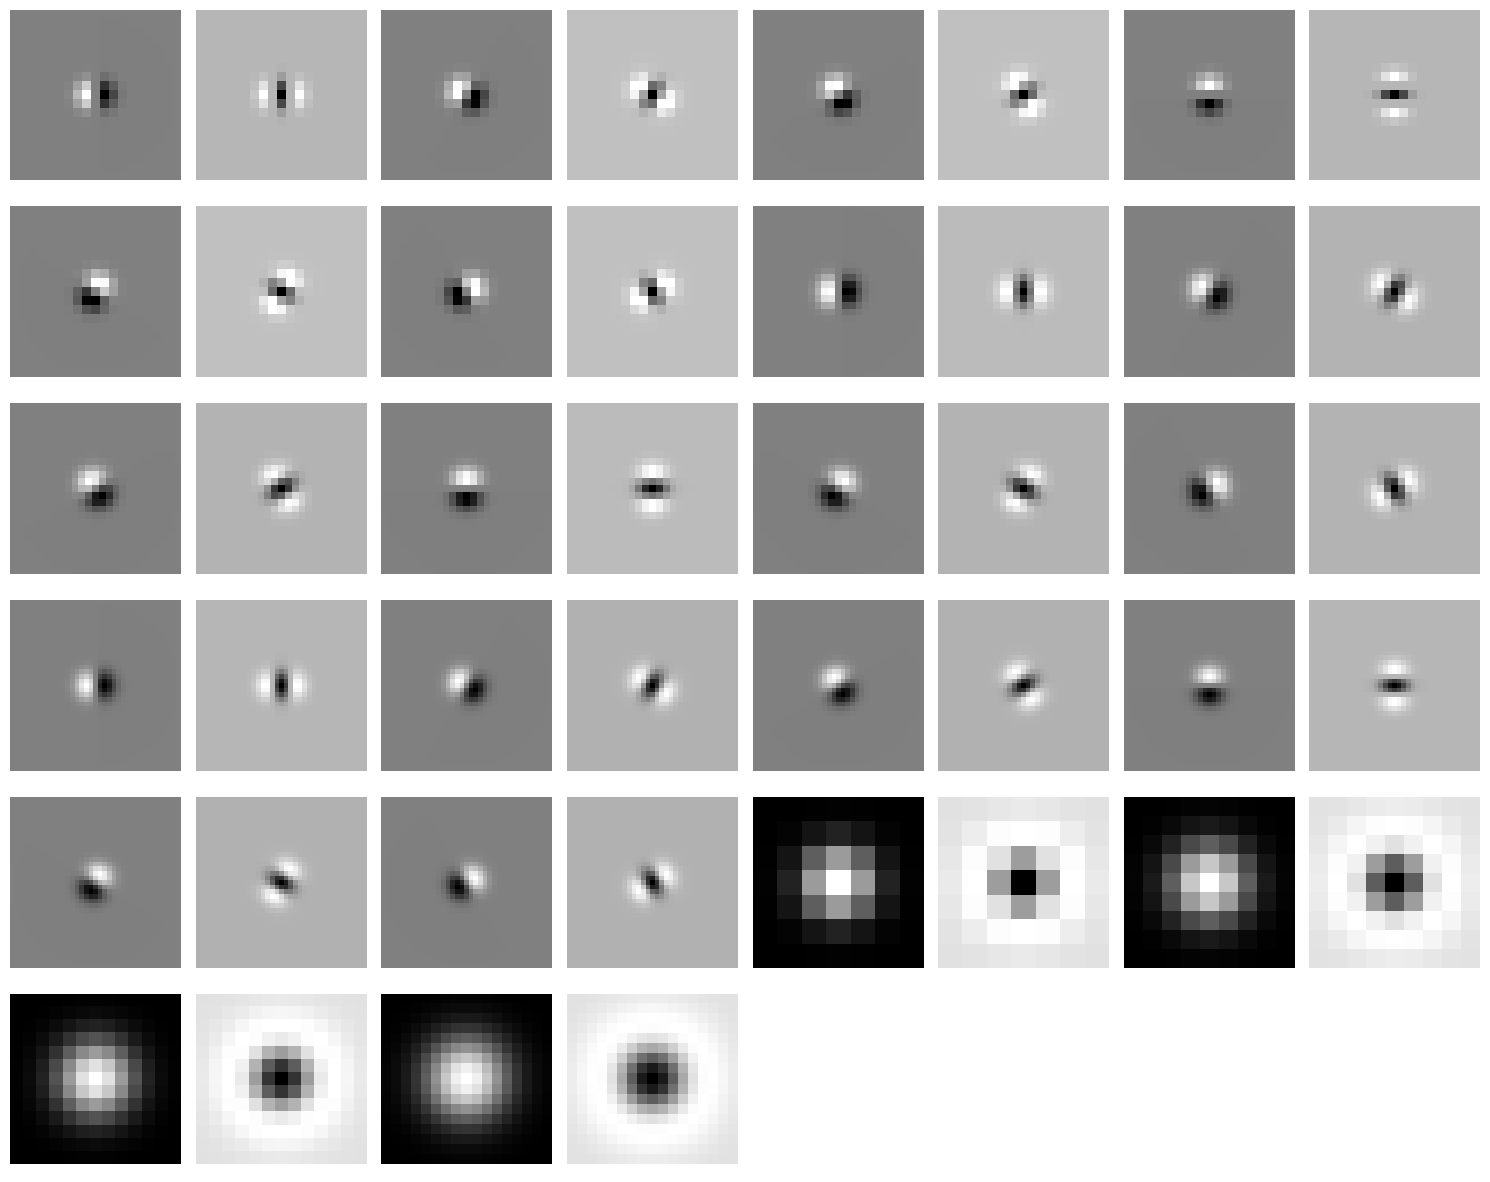

LM filter bank saved as 'LM.png'


In [29]:
### TEST2
def create_derivative_filters(size, sigma, theta, derivative_order):
    """
    Creates oriented derivative filters of specified order
    Args:
        size: Kernel size
        sigma: Standard deviation of Gaussian
        theta: Orientation angle in degrees
        derivative_order: 1 for first derivative, 2 for second derivative
    Returns:
        Oriented derivative filter
    """
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)

    # Rotate coordinates
    theta_rad = np.deg2rad(theta)
    x_theta = x * np.cos(theta_rad) + y * np.sin(theta_rad)
    y_theta = -x * np.sin(theta_rad) + y * np.cos(theta_rad)

    # Create Gaussian
    gaussian = np.exp(-(x_theta**2 + y_theta**2) / (2 * sigma**2))

    # Apply derivative operator
    if derivative_order == 1:
        derivative = (-x_theta / (sigma**2)) * gaussian
    else:  # derivative_order == 2
        derivative = ((x_theta**2 / sigma**4) - 1/sigma**2) * gaussian

    return derivative / np.abs(derivative).sum()

def create_log_filter(size, sigma):
    """
    Creates a Laplacian of Gaussian (LoG) filter
    Args:
        size: Kernel size
        sigma: Standard deviation of Gaussian
    Returns:
        LoG filter
    """
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)
    r_squared = x**2 + y**2

    # Create Gaussian
    gaussian = np.exp(-r_squared / (2 * sigma**2))

    # Apply Laplacian operator
    log = (r_squared - 2*sigma**2) / (sigma**4) * gaussian
    return log / np.abs(log).sum()

def generate_lm_filter_bank():
    """
    Generates the complete Leung-Malik filter bank
    Returns:
        List of LM filters
    """
    filters = []

    # Define parameters
    scales = [1, np.sqrt(2), 2, 2*np.sqrt(2)]  # Basic scales
    orientations = 6  # Number of orientations
    elongation = 3  # Elongation factor for derivative filters

    # First and second derivative filters at first 3 scales
    for scale in scales[:3]:
        sigma = scale
        size = int(6 * sigma * elongation)
        if size % 2 == 0:
            size += 1

        # Generate filters at different orientations
        for theta in range(orientations):
            angle = (180.0 / orientations) * theta

            # First derivative
            first_derivative = create_derivative_filters(size, sigma, angle, 1)
            filters.append(first_derivative)

            # Second derivative
            second_derivative = create_derivative_filters(size, sigma, angle, 2)
            filters.append(second_derivative)

    # Gaussian and LoG filters at all scales
    for scale in scales:
        size = int(6 * scale)
        if size % 2 == 0:
            size += 1

        # Gaussian
        gaussian = gaussian_kernel(size, scale)
        filters.append(gaussian)

        # Laplacian of Gaussian
        log = create_log_filter(size, scale)
        filters.append(log)

    return filters

# Generate filter bank
lm_filter_bank = generate_lm_filter_bank()

# Calculate display dimensions
n_filters = len(lm_filter_bank)
n_cols = 8
n_rows = (n_filters + n_cols - 1) // n_cols

# Display the filter bank
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    if i < n_filters:
        ax.imshow(lm_filter_bank[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Save the filter bank as an image
filter_size = 49  # Standard size for all filters
lm_image = np.zeros((n_rows * filter_size, n_cols * filter_size))

for i in range(n_filters):
    row = i // n_cols
    col = i % n_cols
    filter_resized = cv2.resize(lm_filter_bank[i], (filter_size, filter_size))
    lm_image[row * filter_size:(row + 1) * filter_size,
             col * filter_size:(col + 1) * filter_size] = filter_resized

cv2.imwrite("LM.png", (lm_image * 255).astype(np.uint8))
print("LM filter bank saved as 'LM.png'")

1. Generate Gabor Filter Bank: (Gabor)
2. Display all the filters in this filter bank and save image as Gabor.png,
3. use command "cv2.imwrite(...)"


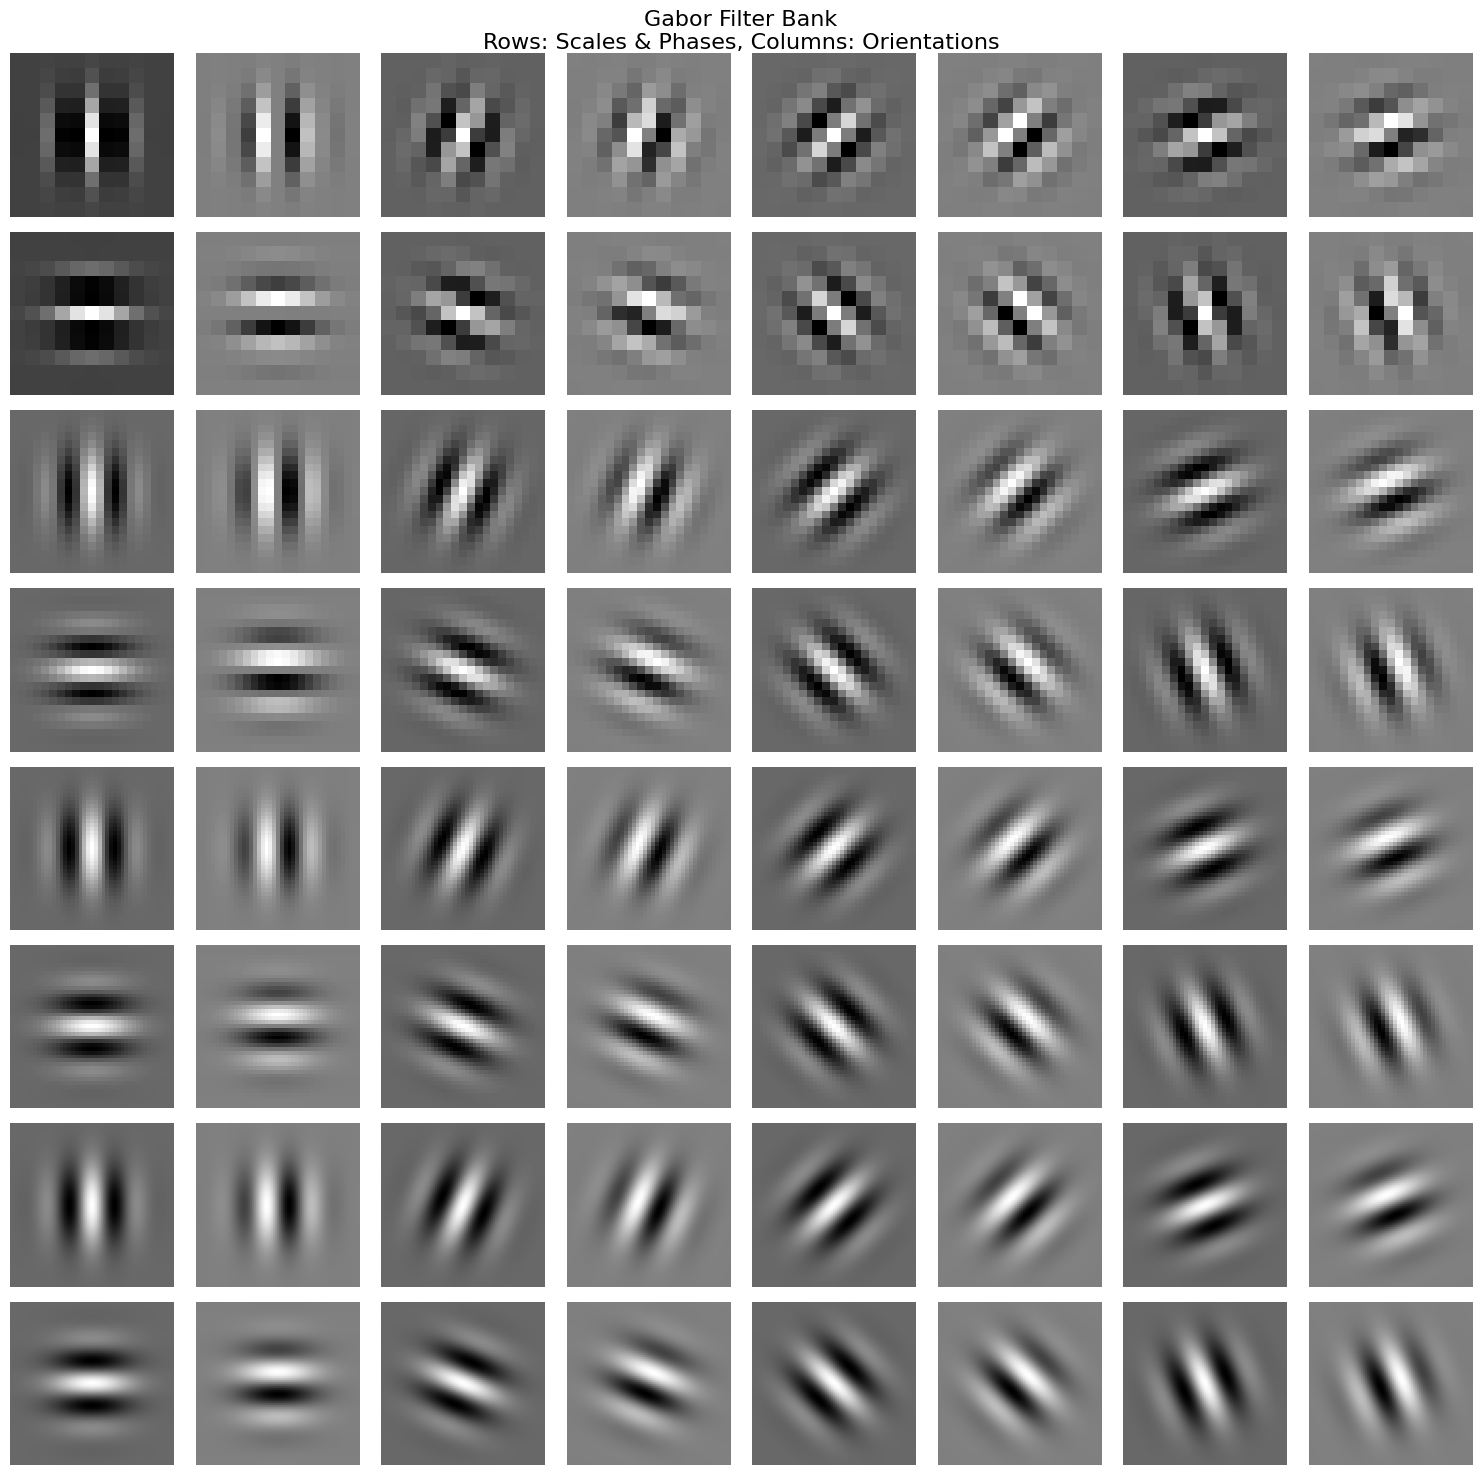

Gabor filter bank saved as 'Gabor.png'

Gabor Filter Bank Summary:
Number of scales: 4
Number of orientations: 8
Number of phases per filter: 2 (even and odd)
Total number of filters: 64


In [32]:
def create_gabor_kernel(size, sigma, theta, frequency, phase_offset=0):
    """
    Creates a single Gabor filter kernel.

    A Gabor filter combines a Gaussian envelope with a sinusoidal wave.
    This makes it excellent for detecting oriented textures.

    Args:
        size: Size of the kernel (must be odd)
        sigma: Standard deviation of the Gaussian envelope
        theta: Orientation of the filter in degrees
        frequency: Frequency of the sinusoidal wave
        phase_offset: Phase offset of the sinusoidal wave (default=0)

    Returns:
        2D Gabor kernel normalized to ensure consistent response
    """
    # Ensure odd size for kernel
    if size % 2 == 0:
        size += 1

    # Create coordinate grid centered at zero
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)

    # Convert orientation to radians
    theta_rad = np.deg2rad(theta)

    # Rotate coordinates
    x_theta = x * np.cos(theta_rad) + y * np.sin(theta_rad)
    y_theta = -x * np.sin(theta_rad) + y * np.cos(theta_rad)

    # Create Gaussian envelope
    gaussian = np.exp(-(x_theta**2 + y_theta**2) / (2 * sigma**2))

    # Create sinusoidal wave
    sinusoid = np.cos(2 * np.pi * frequency * x_theta + phase_offset)

    # Combine Gaussian and sinusoid to create Gabor filter
    gabor = gaussian * sinusoid

    # Normalize the filter
    return gabor / np.abs(gabor).sum()

def generate_gabor_filter_bank(scales=9, orientations=8):
    """
    Generates a bank of Gabor filters at different scales and orientations.

    The filter bank includes filters at multiple:
    - Scales (to detect textures of different sizes)
    - Orientations (to detect textures in different directions)
    - Phases (to capture both symmetric and antisymmetric patterns)

    Args:
        scales: Number of different scales to generate
        orientations: Number of different orientations to generate

    Returns:
        List of Gabor filters
    """
    filters = []

    # Calculate wavelengths for different scales
    # We use wavelength progression that doubles at each scale
    wavelengths = [np.pi * (2**i) for i in range(scales)]

    # Define the ratio between sigma and wavelength
    # This ratio is chosen empirically to balance filter response
    sigma_ratio = 0.56

    # Generate filters for each scale
    for wavelength in wavelengths:
        # Calculate sigma based on wavelength
        sigma = wavelength * sigma_ratio

        # Calculate frequency (inverse of wavelength)
        frequency = 1.0 / wavelength

        # Calculate kernel size based on sigma
        size = int(6 * sigma)  # Use 6*sigma rule to capture most of Gaussian
        if size % 2 == 0:
            size += 1

        # Generate filters at different orientations
        for theta in range(orientations):
            # Calculate angle in degrees
            angle = (180.0 / orientations) * theta

            # Create filter with phase = 0 (even/symmetric)
            even_filter = create_gabor_kernel(size, sigma, angle, frequency, 0)
            filters.append(even_filter)

            # Create filter with phase = pi/2 (odd/antisymmetric)
            odd_filter = create_gabor_kernel(size, sigma, angle, frequency, np.pi/2)
            filters.append(odd_filter)

    return filters

# Generate the Gabor filter bank
gabor_filter_bank = generate_gabor_filter_bank(scales=4, orientations=8)

# Calculate display dimensions
n_filters = len(gabor_filter_bank)
n_cols = 8
n_rows = (n_filters + n_cols - 1) // n_cols

# Create figure for visualization
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
fig.suptitle('Gabor Filter Bank\nRows: Scales & Phases, Columns: Orientations', fontsize=16)

# Display all filters
for i, ax in enumerate(axes.flat):
    if i < n_filters:
        # Normalize filter for visualization
        filter_viz = gabor_filter_bank[i]
        filter_viz = (filter_viz - filter_viz.min()) / (filter_viz.max() - filter_viz.min())
        ax.imshow(filter_viz, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Save the filter bank as an image
filter_size = 49  # Standard size for all filters
gabor_image = np.zeros((n_rows * filter_size, n_cols * filter_size))

for i in range(n_filters):
    row = i // n_cols
    col = i % n_cols

    # Resize and normalize filter for visualization
    filter_resized = cv2.resize(gabor_filter_bank[i], (filter_size, filter_size))
    filter_resized = (filter_resized - filter_resized.min()) / (filter_resized.max() - filter_resized.min())

    # Place filter in the image
    gabor_image[row * filter_size:(row + 1) * filter_size,
                col * filter_size:(col + 1) * filter_size] = filter_resized

# Save the image
cv2.imwrite("Gabor.png", (gabor_image * 255).astype(np.uint8))
print("Gabor filter bank saved as 'Gabor.png'")

# Print filter bank information
print(f"\nGabor Filter Bank Summary:")
print(f"Number of scales: 4")
print(f"Number of orientations: 8")
print(f"Number of phases per filter: 2 (even and odd)")
print(f"Total number of filters: {n_filters}")

1. Generate Half-disk masks
2. Display all the Half-disk masks and save image as HDMasks.png,
3. use command "cv2.imwrite(...)"

Half-disk mask bank saved as Half_Disk_Masks.png


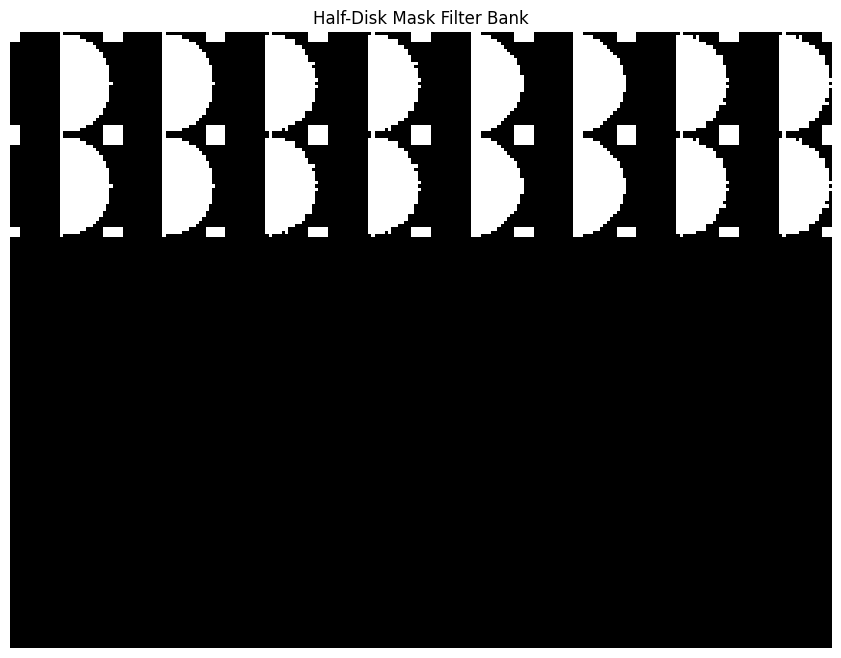

In [36]:
def create_half_disk_mask(radius, angle, with_corners=True):
    """
    Creates a half-disk mask with corner markers for visual reference.

    Args:
        radius: Radius of the half-disk
        angle: Rotation angle in degrees
        with_corners: Whether to add corner markers

    Returns:
        Binary mask with the half-disk pattern
    """
    # Create a larger mask size to accommodate rotation and corners
    size = 2 * radius + 1
    mask = np.zeros((size, size), dtype=np.uint8)
    center = (size // 2, size // 2)

    # Draw the basic half-disk
    cv2.circle(mask, center, radius, 1, -1)  # Full circle

    # Create rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(mask, M, (size, size))

    # Split into half
    half_mask = np.zeros_like(rotated)
    half_mask[:, size//2:] = rotated[:, size//2:]

    if with_corners:
        # Add corner markers (3x3 squares)
        corner_size = max(2, size // 8)

        # Add corners in all four corners
        half_mask[:corner_size, :corner_size] = 1  # Top-left
        half_mask[:corner_size, -corner_size:] = 1  # Top-right
        half_mask[-corner_size:, :corner_size] = 1  # Bottom-left
        half_mask[-corner_size:, -corner_size:] = 1  # Bottom-right

    return half_mask

def generate_half_disk_filter_bank():
    """
    Generates a complete bank of half-disk masks at different orientations
    with consistent corner markers.

    Returns:
        List of masks organized in pairs (left and right half-disks)
    """
    filters = []
    radius = 15  # Fixed radius for all masks
    num_orientations = 8  # Number of orientation pairs

    for i in range(num_orientations):
        angle = i * (180.0 / num_orientations)

        # Create right half-disk
        right_mask = create_half_disk_mask(radius, angle)

        # Create left half-disk (rotated 180 degrees)
        left_mask = create_half_disk_mask(radius, angle + 180)

        # Add both masks
        filters.extend([right_mask, left_mask])

    return filters

def visualize_half_disk_masks(save_path="Half_Disk_Masks.png"):
    """
    Creates and saves a visualization of the half-disk mask bank
    matching the expected layout.
    """
    # Generate filter bank
    filters = generate_half_disk_filter_bank()

    # Create the display grid (6 rows x 8 columns)
    rows, cols = 6, 8
    cell_size = 31  # Size of each mask display cell

    # Create the full image canvas
    full_image = np.zeros((rows * cell_size, cols * cell_size), dtype=np.uint8)

    # Place each mask in the grid
    for idx, mask in enumerate(filters):
        row = idx // cols
        col = idx % cols

        # Center the mask in its cell
        y_start = row * cell_size
        x_start = col * cell_size

        # Resize mask if needed
        mask_resized = cv2.resize(mask, (cell_size, cell_size),
                                interpolation=cv2.INTER_NEAREST)

        # Place the mask
        full_image[y_start:y_start + cell_size,
                  x_start:x_start + cell_size] = mask_resized * 255

    # Save the visualization
    cv2.imwrite(save_path, full_image)
    print(f"Half-disk mask bank saved as {save_path}")

    # Display the result
    plt.figure(figsize=(12, 8))
    plt.imshow(full_image, cmap='gray')
    plt.axis('off')
    plt.title('Half-Disk Mask Filter Bank')
    plt.show()

# Generate and save the visualization
visualize_half_disk_masks()

1. Generate Texton Map
2. Filter image using oriented gaussian filter bank


1. Generate texture ID's using K-means clustering
2. Display texton map and save image as TextonMap_ImageName.png,
3. use command "cv2.imwrite('...)"


1. Generate Texton Gradient (Tg)
2. Perform Chi-square calculation on Texton Map
3. Display Tg and save image as Tg_ImageName.png,
4. use command "cv2.imwrite(...)"


1. Generate Brightness Map
2. Perform brightness binning


1. Generate Brightness Gradient (Bg)
2. Perform Chi-square calculation on Brightness Map
3. Display Bg and save image as Bg_ImageName.png,
4. use command "cv2.imwrite(...)"



1. Generate Color Map
2. Perform color binning or clustering





1. Generate Color Gradient (Cg)
2. Perform Chi-square calculation on Color Map
3. Display Cg and save image as Cg_ImageName.png,
4. use command "cv2.imwrite(...)"




1. Read Sobel Baseline
2. use command "cv2.imread(...)"





1. Read Canny Baseline
2. use command "cv2.imread(...)"





1. Combine responses to get pb-lite output
2. Display PbLite and save image as PbLite_ImageName.png
3. use command "cv2.imwrite(...)"



## Phase 2

### Neural Network Construction

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    loss = ...
    return loss

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, result['loss'], result['acc']))



class CIFAR10Model(ImageClassificationBase):
  def __init__(self, InputSize, OutputSize):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################


  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################

      return out


In [ ]:
import time
import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime

def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)

### Train your neural network

In [ ]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm

def SetupAll(CheckPointPath):
    """
    Inputs:
    CheckPointPath - Path to save checkpoints/model
    Outputs:
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    ImageSize - Size of the image
    NumTrainSamples - length(Train)
    TrainLabels - Labels corresponding to Train
    NumClasses - Number of classes
    """
    # Read and Setup Labels
    LabelsPathTrain = '/content/data/TxtFiles/LabelsTrain.txt'
    TrainLabels = ReadLabels(LabelsPathTrain)

    # If CheckPointPath doesn't exist make the path
    if(not (os.path.isdir(CheckPointPath))):
       os.makedirs(CheckPointPath)

    # Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    SaveCheckPoint = 100

    # Image Input Shape
    ImageSize = [32, 32, 3]
    NumTrainSamples = len(TrainSet)

    # Number of classes
    NumClasses = 10

    return SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses


def ReadLabels(LabelsPathTrain):
    if(not (os.path.isfile(LabelsPathTrain))):
        print('ERROR: Train Labels do not exist in '+LabelsPathTrain)
        sys.exit()
    else:
        TrainLabels = open(LabelsPathTrain, 'r')
        TrainLabels = TrainLabels.read()
        TrainLabels = map(float, TrainLabels.split())

    return TrainLabels


def ReadDirNames(ReadPath):
    """
    Inputs:
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames is the data loaded from /content/data/TxtFiles/DirNames.txt which has full path to all image files without extension
    """
    # Read text files
    DirNames = open(ReadPath, 'r')
    DirNames = DirNames.read()
    DirNames = DirNames.split()
    return DirNames


def GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize):
    """
    Inputs:
    TrainSet - Variable with Subfolder paths to train files
    NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
    TrainLabels - Labels corresponding to Train
    NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
    ImageSize is the Size of the Image
    MiniBatchSize is the size of the MiniBatch

    Outputs:
    I1Batch - Batch of images
    LabelBatch - Batch of one-hot encoded labels
    """
    I1Batch = []
    LabelBatch = []

    ImageNum = 0
    while ImageNum < MiniBatchSize:
        # Generate random image
        RandIdx = random.randint(0, len(TrainSet)-1)

        ImageNum += 1

    	  ##########################################################
    	  # Add any standardization or data augmentation here!
    	  ##########################################################

        I1, Label = TrainSet[RandIdx]

        # Append All Images and Mask
        I1Batch.append(I1)
        LabelBatch.append(torch.tensor(Label))

    return torch.stack(I1Batch), torch.stack(LabelBatch)


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
    """
    Prints all stats with all arguments
    """
    print('Number of Epochs Training will run for ' + str(NumEpochs))
    print('Factor of reduction in training data is ' + str(DivTrain))
    print('Mini Batch Size ' + str(MiniBatchSize))
    print('Number of Training Images ' + str(NumTrainSamples))
    if LatestFile is not None:
        print('Loading latest checkpoint with the name ' + LatestFile)

def TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                   NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                   DivTrain, LatestFile, TrainSet, LogsPath):
    """
    Inputs:
    TrainLabels - Labels corresponding to Train/Test
    NumTrainSamples - length(Train)
    ImageSize - Size of the image
    NumEpochs - Number of passes through the Train data
    MiniBatchSize is the size of the MiniBatch
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    CheckPointPath - Path to save checkpoints/model
    DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
    LatestFile - Latest checkpointfile to continue training
    TrainSet - The training dataset
    LogsPath - Path to save Tensorboard Logs
    Outputs:
    Saves Trained network in CheckPointPath and Logs to LogsPath
    """
    # Initialize the model
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10)
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
    Optimizer = ...

    # Tensorboard
    # Create a summary to monitor loss tensor
    Writer = SummaryWriter(LogsPath)

    if LatestFile is not None:
        CheckPoint = torch.load(CheckPointPath + LatestFile + '.ckpt')
        # Extract only numbers from the name
        StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
        model.load_state_dict(CheckPoint['model_state_dict'])
        print('Loaded latest checkpoint with the name ' + LatestFile + '....')
    else:
        StartEpoch = 0
        print('New model initialized....')

    for Epochs in tqdm(range(StartEpoch, NumEpochs)):
        NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
        for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
            Batch = GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize)

            # Predict output with forward pass
            LossThisBatch = model.training_step(Batch)

            Optimizer.zero_grad()
            LossThisBatch.backward()
            Optimizer.step()

            # Save checkpoint every some SaveCheckPoint's iterations
            if PerEpochCounter % SaveCheckPoint == 0:
                # Save the Model learnt in this epoch
                SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'

                torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
                print('\n' + SaveName + ' Model Saved...')

            result = model.validation_step(Batch)
            model.epoch_end(Epochs*NumIterationsPerEpoch + PerEpochCounter, result)
            # Tensorboard
            Writer.add_scalar('LossEveryIter', result["loss"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            Writer.add_scalar('Accuracy', result["acc"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            # If you don't flush the tensorboard doesn't update until a lot of iterations!
            Writer.flush()

        # Save model every epoch
        SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
        torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
        print('\n' + SaveName + ' Model Saved...')



# Default Hyperparameters
NumEpochs = 50
TrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=ToTensor())
DivTrain = 1.0
MiniBatchSize = 1
LoadCheckPoint = 0
CheckPointPath = "/content/Checkpoints/"
LogsPath = "/content/Logs"

# Setup all needed parameters including file reading
SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses = SetupAll(CheckPointPath)

# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, TrainSet, LogsPath)

### Test your neural network

In [ ]:
import cv2
import os
import sys
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch

def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """
    # Image Input Shape
    ImageSize = [32, 32, 3]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img

def ReadImages(Img):
    """
    Outputs:
    I1Combined - I1 image after any standardization and/or cropping/resizing to ImageSize
    I1 - Original I1 image for visualization purposes only
    """
    I1 = Img

    if(I1 is None):
        # OpenCV returns empty list if image is not read!
        print('ERROR: Image I1 cannot be read')
        sys.exit()

    I1S = StandardizeInputs(np.float32(I1))

    I1Combined = np.expand_dims(I1S, axis=0)

    return I1Combined, I1


def TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred):
    """
    Inputs:
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to /content/data/TxtFiles/PredOut.txt
    """
    # Predict output with forward pass, MiniBatchSize for Test is 1
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10)

    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    print('Number of parameters in this model are %d ' % len(model.state_dict().items()))

    OutSaveT = open(LabelsPathPred, 'w')

    for count in tqdm(range(len(TestSet))):
        Img, Label = TestSet[count]
        Img, ImgOrg = ReadImages(Img)
        PredT = torch.argmax(model(Img)).item()

        OutSaveT.write(str(PredT)+'\n')
    OutSaveT.close()

def Accuracy(Pred, GT):
    """
    Inputs:
    Pred are the predicted labels
    GT are the ground truth labels
    Outputs:
    Accuracy in percentage
    """
    return (np.sum(np.array(Pred)==np.array(GT))*100.0/len(Pred))

def ReadLabels(LabelsPathTest, LabelsPathPred):
    if(not (os.path.isfile(LabelsPathTest))):
        print('ERROR: Test Labels do not exist in '+LabelsPathTest)
        sys.exit()
    else:
        LabelTest = open(LabelsPathTest, 'r')
        LabelTest = LabelTest.read()
        LabelTest = map(float, LabelTest.split())

    if(not (os.path.isfile(LabelsPathPred))):
        print('ERROR: Pred Labels do not exist in '+LabelsPathPred)
        sys.exit()
    else:
        LabelPred = open(LabelsPathPred, 'r')
        LabelPred = LabelPred.read()
        LabelPred = map(float, LabelPred.split())

    return LabelTest, LabelPred

def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.
    LabelsTrue, LabelsPred = list(LabelsTrue), list(LabelsPred)
    cm = confusion_matrix(y_true=LabelsTrue,  # True class for test-set.
                          y_pred=LabelsPred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        print(str(cm[i, :]) + ' ({0})'.format(i))

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(10)]
    print("".join(class_numbers))

    print('Accuracy: '+ str(Accuracy(LabelsPred, LabelsTrue)), '%')


ModelPath = "/content/Checkpoints/0a100model.ckpt"
LabelsPath = "/content/data/TxtFiles/LabelsTest.txt"
TestSet = CIFAR10(root='data/', train=False)


# Setup all needed parameters including file reading
ImageSize = SetupAll()

# Define PlaceHolder variables for Input and Predicted output
LabelsPathPred = '/content/data/TxtFiles/PredOut.txt' # Path to save predicted labels

TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred)

# Plot Confusion Matrix
LabelsTrue, LabelsPred = ReadLabels(LabelsPath, LabelsPathPred)
ConfusionMatrix(LabelsTrue, LabelsPred)